In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [4]:
crypto_currency = 'ETH'
against_currency = 'USD'

start = dt.datetime(2016,1,1)
end = dt.datetime.now()

data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', start, end)

In [8]:
print(data)

                   High          Low         Open        Close        Volume  \
Date                                                                           
2016-01-01     0.954822     0.931442     0.933712     0.948024  2.060620e+05   
2016-01-02     0.969637     0.936560     0.947401     0.937124  2.555040e+05   
2016-01-03     0.991362     0.934313     0.938430     0.971905  4.076320e+05   
2016-01-04     0.976438     0.929835     0.972045     0.954480  3.462450e+05   
2016-01-05     0.970597     0.946543     0.953147     0.950176  2.198330e+05   
...                 ...          ...          ...          ...           ...   
2021-08-21  3272.733154  3142.007080  3226.227295  3242.115479  1.598328e+10   
2021-08-22  3373.384277  3235.851318  3241.357422  3319.257324  2.051111e+10   
2021-08-23  3358.688232  3154.121338  3324.855469  3172.456299  2.013103e+10   
2021-08-24  3248.727295  3086.114990  3174.269775  3224.915283  1.890273e+10   
2021-08-26  3247.775391  3062.338867  32

In [9]:
#Prepare Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [11]:
#Seperate training data
prediction_days = 60

x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [15]:
#Create the Model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer="adam", loss="mean_squared_error")

In [16]:
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
63/63 [==============================] - 11s 20ms/step - loss: 0.0045
Epoch 2/25
63/63 [==============================] - 1s 19ms/step - loss: 0.0019
Epoch 3/25
63/63 [==============================] - 1s 19ms/step - loss: 0.0016
Epoch 4/25
63/63 [==============================] - 1s 18ms/step - loss: 0.0021
Epoch 5/25
63/63 [==============================] - 1s 19ms/step - loss: 0.0013
Epoch 6/25
63/63 [==============================] - 1s 19ms/step - loss: 0.0011
Epoch 7/25
63/63 [==============================] - 1s 19ms/step - loss: 0.0012
Epoch 8/25
63/63 [==============================] - 1s 19ms/step - loss: 0.0012
Epoch 9/25
63/63 [==============================] - 1s 20ms/step - loss: 0.0011
Epoch 10/25
63/63 [==============================] - 1s 18ms/step - loss: 0.0013
Epoch 11/25
63/63 [==============================] - 1s 19ms/step - loss: 0.0010
Epoch 12/25
63/63 [==============================] - 1s 19ms/step - loss: 9.0081e-04
Epoch 13/25
63/63 [=============

In [18]:
#Evaluate the Model
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', test_start, test_end)

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']),axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.fit_transform(model_inputs)

In [20]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [21]:
#Prediction Prices
prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

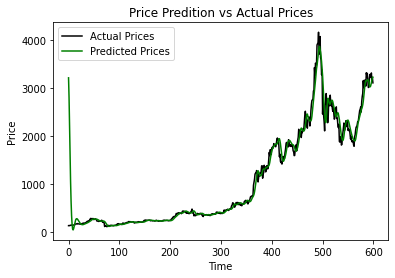

In [23]:
plt.plot(actual_prices, color="black", label="Actual Prices")
plt.plot(prediction_prices, color="green", label="Predicted Prices")
plt.title("Price Predition vs Actual Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(loc="upper left")
plt.show()

In [25]:
#Predict next day
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs) + 1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(prediction)

[[3215.1592]]
